In [2]:
import geopandas as gpd
import pandas as pd
import json
import xarray as xr

import odp.geospatial as odp
import geopandas as gpd
import pandas as pd
import matplotlib.dates as md
import dateutil
import numpy as np

import sqlite3

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean

import matplotlib.cm as cm
from math import pi, sqrt
import pickle
import os
import warnings
warnings.filterwarnings("ignore")
import azure.storage.blob 
import zarr
import altair as alt
import hvplot.xarray
import cmocean

In [3]:
db=odp.Database()
db_plt = odp.PlotTools()

Necessary code to connect to storage in database

In [4]:
blob_service_client=azure.storage.blob.BlobServiceClient.from_connection_string(os.environ['ODE_CONNECTION_STR'])

In [5]:
container_client = blob_service_client.get_container_client('crw')

In [6]:
container='crw'
folder='zarr/'

### Pulling the data

In [7]:
file_list = list(set([b.name for b in container_client.walk_blobs(folder, delimiter='/')  ]))
file_list.sort()

In [8]:
%%time

store_list=[]
for year in range(1985,2023):
    result = list(filter(lambda x: "_"+str(year)+"_" in x, file_list))
    for file in result:
            store=zarr.ABSStore(prefix=file,client=container_client)
            store_list.append(store)
data=xr.open_mfdataset(store_list, parallel=True, engine='zarr')

CPU times: user 18.7 s, sys: 2.08 s, total: 20.8 s
Wall time: 19.1 s


### The oupt is an xarray dataset which is a multi-dimensional, in memory, array database

In [9]:
data

<xarray.Dataset>
Dimensions:           (time: 13603, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon               (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time              (time) datetime64[ns] 1985-01-01T12:00:00 ... 2022-03-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 450, 900), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 450, 1800), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

### Import the polygon of Florida and Northern Caribbean using geopandas

In [9]:
poly = gpd.read_file('boundary.geojson')
poly.head()

name  \
0  Northern Caribbean, Florida, & Bahamas   

                                            geometry  
0  MULTIPOLYGON (((-83.74803 29.79798, -83.76670 ...

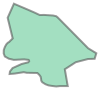

In [10]:
poly['geometry'][0]

### Figure out the bounding box for our area of interest

In [11]:
coords = list(poly["geometry"][0].envelope.exterior.coords)
coords

[(-85.55076, 15.961632),
 (-70.021079, 15.961632),
 (-70.021079, 29.840357),
 (-85.55076, 29.840357),
 (-85.55076, 15.961632)]

### Take a slice of the temperature data only for the area we care about (the bounding box we created)

In [12]:
ds_slice =data.sel(lon=slice(coords[0][0],coords[1][0]), lat=slice(coords[0][1], coords[2][1]))
ds_slice

<xarray.Dataset>
Dimensions:           (time: 13603, lat: 278, lon: 311)
Coordinates:
  * lat               (lat) float32 15.98 16.02 16.08 ... 29.73 29.77 29.83
  * lon               (lon) float32 -85.53 -85.47 -85.43 ... -70.07 -70.03
  * time              (time) datetime64[ns] 1985-01-01T12:00:00 ... 2022-03-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 131, 311), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 131, 311), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

## Let's take a look at 2005, a year with a lot of coral bleaching in the caribbean

In [13]:
ds_2005 = ds_slice.isel(time=(ds_slice.time.dt.year == 2005))

### With built in xarray functions we can easily visualize the data

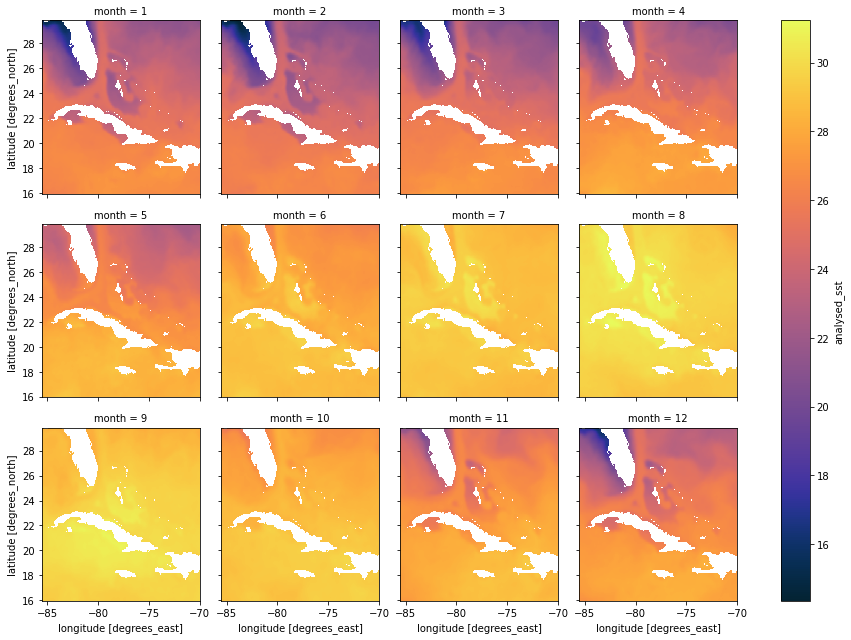

In [14]:
monthly_means = ds_2005.groupby("time.month").mean()
fg = monthly_means.analysed_sst.plot(
    col="month",
    col_wrap=4,
    cmap=cmocean.cm.thermal,
)

### And even see it play over time!

In [17]:
ds_2005.hvplot(
    groupby="time",
    clim=(15, 35),
    widget_type="scrubber",
    widget_location="bottom",
)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=364, width=550)
        [2] HSpacer()

### We can also turn it into a pandas dataframe that more people are familiar with to do things like groupbys

Let's take a smaller time subset of the xarray

In [10]:
ds_slice =data.sel(lon=slice(-80,-78), lat=slice(20, 22), time=slice('1990-01-01', '2022-01-01'))
ds_slice

<xarray.Dataset>
Dimensions:           (time: 11689, lat: 40, lon: 40)
Coordinates:
  * lat               (lat) float32 20.02 20.08 20.12 ... 21.88 21.92 21.98
  * lon               (lon) float32 -79.97 -79.93 -79.88 ... -78.07 -78.03
  * time              (time) datetime64[ns] 1990-01-01T12:00:00 ... 2022-01-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

In [12]:
%%time
df = ds_slice.to_dataframe().reset_index() ## This can take some time depending on size of slice
df['time'] = pd.to_datetime(df['time'],format='%m/%d/%y %I:%M%p')
df['mnth_yr'] = df.time.dt.to_period('M').astype(str)
df['year'] = df.time.dt.year.astype(str)
df['month'] = df.time.dt.month.astype(int)

CPU times: user 5min 14s, sys: 25.2 s, total: 5min 39s
Wall time: 5min 6s


In [13]:
df.head()

time     lat        lon  analysed_sst    crs  \
0 1990-01-01 12:00:00  20.025 -79.974998     26.119999 -32767   
1 1990-01-01 12:00:00  20.025 -79.925003     26.129999 -32767   
2 1990-01-01 12:00:00  20.025 -79.875000     26.129999 -32767   
3 1990-01-01 12:00:00  20.025 -79.824997     26.150000 -32767   
4 1990-01-01 12:00:00  20.025 -79.775002     26.150000 -32767   

   sea_ice_fraction  mnth_yr  year  month  
0               0.0  1990-01  1990      1  
1               0.0  1990-01  1990      1  
2               0.0  1990-01  1990      1  
3               0.0  1990-01  1990      1  
4               0.0  1990-01  1990      1

### This is taking a lot of liberties of grouping this giant area together <br> Will be better when we have exat locations of reefs

In [20]:
df_plot = df.groupby(['mnth_yr', 'year','month']).agg({'analysed_sst': ['mean', 'min', 'max']}).reset_index()
df_plot.columns=['mnth_yr','year','month','mean','min','max']


In [21]:
df_plot

mnth_yr  year  month       mean        min        max
0    1990-01  1990      1  26.025499  24.029999  27.439999
1    1990-02  1990      2  26.174719  24.619999  27.330000
2    1990-03  1990      3  25.914995  24.350000  27.269999
3    1990-04  1990      4  26.847609  25.510000  27.920000
4    1990-05  1990      5  27.846371  25.939999  29.129999
..       ...   ...    ...        ...        ...        ...
380  2021-09  2021      9  30.067915  29.219999  31.059999
381  2021-10  2021     10  29.796970  28.689999  30.679998
382  2021-11  2021     11  28.490704  25.570000  29.779999
383  2021-12  2021     12  27.325579  24.779999  28.809999
384  2022-01  2022      1  26.907465  25.379999  27.719999

[385 rows x 6 columns]

In [22]:
selection = alt.selection_multi(fields=['year'], bind="legend")
chart = alt.Chart(df_plot).mark_line().encode(
            x=alt.X("month", title="Month", sort="ascending"),
            y=alt.Y('mean', title='Monthly mean temperature',scale=alt.Scale(domain=(22,33))),
            color=alt.Color('year', title="Year",
                            scale=alt.Scale(domain=df_plot["year"].unique(), scheme="paired")),
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
            # tooltip=[alt.Tooltip('mean', title='Mean Temperature')],
            tooltip=['mean', 'year'],
)


line = alt.Chart(pd.DataFrame({'mean': [30.5]})).mark_rule().encode(y='mean', color=alt.value("#FF0000"),strokeWidth=alt.value(3))

alt.layer(chart, line).configure_view(
    stroke='transparent'
).properties(
            title='Monthly average per year',width=500,height=300
        ).configure_axis(
            labelFontSize=15,
            titleFontSize=15
        ).configure_legend(labelFontSize=12, columns=1, labelLimit=500, symbolLimit=100).add_selection(
            selection
        ).add_selection(
            selection
        )

alt.LayerChart(...)

In [23]:
df_plot = df_plot[df_plot.year =='2005']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


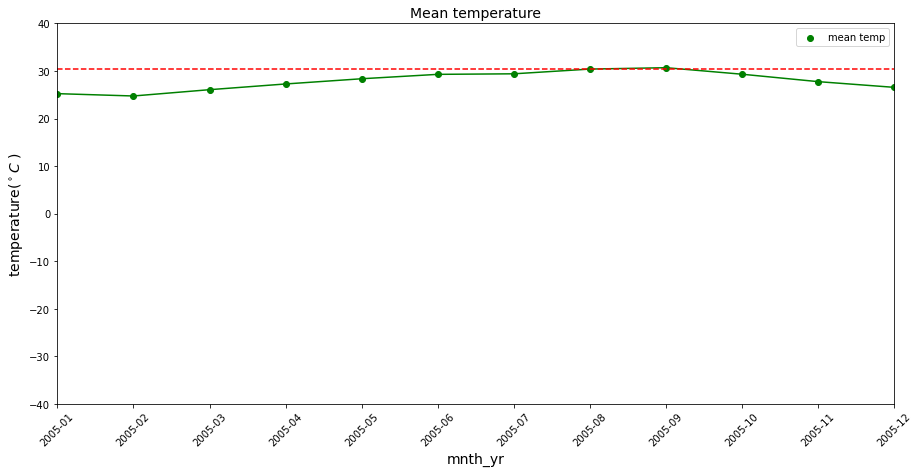

In [27]:
plt.figure(figsize=(15,7))


plt.plot(df_plot['mnth_yr'],df_plot['mean'], 'g')
plt.axhline(y =30.5, color = 'r', linestyle = '--')


plt.legend()
plt.scatter(df_plot['mnth_yr'],df_plot['mean'],c='g',label='mean temp')


plt.xlabel('mnth_yr',size=14)
plt.ylabel('temperature($^\circ C$ )',size=14)
plt.xticks(rotation = 45)
plt.xticks(df_plot['mnth_yr'])
ax=plt.gca()
ax.axis([0,11,-40,40])
plt.title('Mean temperature',size=14)
plt.legend(loc=0)

plt.show()


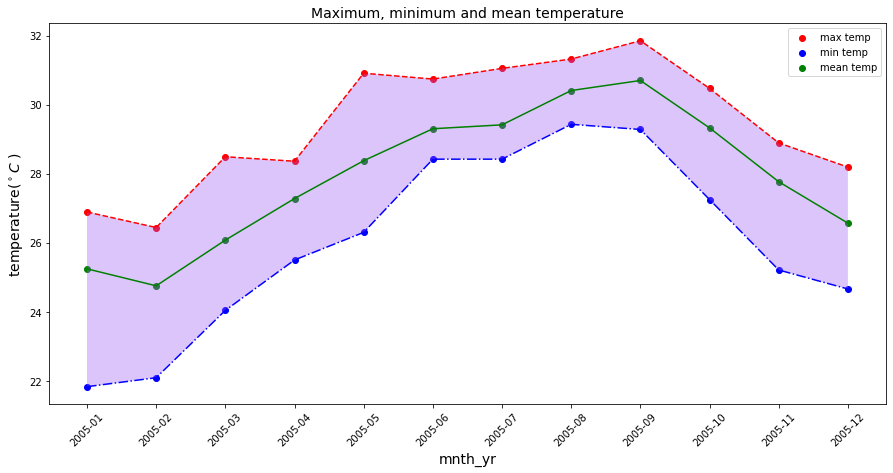

In [25]:
plt.figure(figsize=(15,7))

plt.plot(df_plot['mnth_yr'],df_plot['max'], '--r')
plt.plot(df_plot['mnth_yr'],df_plot['min'], '-.b')
plt.plot(df_plot['mnth_yr'],df_plot['mean'], 'g')
plt.scatter(df_plot['mnth_yr'],df_plot['max'],c='r',label='max temp')
plt.scatter(df_plot['mnth_yr'],df_plot['min'],c='b',label='min temp')
plt.scatter(df_plot['mnth_yr'],df_plot['mean'],c='g',label='mean temp')

plt.xlabel('mnth_yr',size=14)
plt.ylabel('temperature($^\circ C$ )',size=14)
plt.xticks(rotation = 45)
plt.xticks(df_plot['mnth_yr'])
ax=plt.gca()
plt.gca().fill_between(df_plot['mnth_yr'], 
                       df_plot['max'], df_plot['min'], 
                       facecolor='#9D59F4', 
                       alpha=0.35)
plt.title('Maximum, minimum and mean temperature',size=14)
plt.legend(loc=0)

plt.show()


## Now let's try to combine temperature data with coral bleaching data

Let's connect to the global coral bleaching database

In [17]:
df_bl = pd.read_csv('bleaching_data.csv')
df_bl['longitude'] = df_bl.Longitude_Degrees.round()
df_bl['latitude'] = df_bl.Latitude_Degrees.round()

df_bl.head()

Sample_ID  Site_ID  Date_Day  Date_Month  Date_Year  Ecoregion_Name  \
0   10318751       21      12.0        10.0     2004.0            45.0   
1   10318751       21      12.0        10.0     2004.0            45.0   
2   10318758       22      22.0        11.0     2003.0            45.0   
3   10318758       22      22.0        11.0     2003.0            45.0   
4   10323299     1212      15.0         1.0     1991.0             6.0   

   Latitude_Degrees  Longitude_Degrees  Depth_m  Percent_Bleached  ...  \
0         17.168417         -61.818333      8.0               NaN  ...   
1         17.168417         -61.818333      8.0               NaN  ...   
2         17.735278         -61.852222      5.0               NaN  ...   
3         17.735278         -61.852222      5.0               NaN  ...   
4         23.764000         -76.120000     17.0               NaN  ...   

   TSA_Frequency_Standard_Deviation  TSA_FrequencyMax  TSA_FrequencyMean  \
0                              1.18               5.0                0.0   
1                              1.18               5.0                0.0   
2                              1.00               3.0                0.0   
3                              1.00               3.0                0.0   
4                              1.41               6.0                1.0   

   TSA_DHW  TSA_DHW_Standard_Deviation  TSA_DHWMax  TSA_DHWMean  TRIAL501  \
0      0.0                        0.80        6.69         0.23         T   
1      0.0                        0.80        6.69         0.23         T   
2      0.0                        0.77        4.28         0.26         T   
3      0.0                        0.77        4.28         0.26         T   
4      0.0                        1.08        8.60         0.36         T   

   longitude  latitude  
0      -62.0      17.0  
1      -62.0      17.0  
2      -62.0      18.0  
3      -62.0      18.0  
4      -76.0      24.0  

[5 rows x 55 columns]

In [18]:
df_bl[['Date_Year','Bleaching_Level']].groupby('Date_Year').count()

Bleaching_Level
Date_Year                 
1983.0                   6
1987.0                  30
1988.0                   2
1990.0                   1
1991.0                   2
1992.0                   3
1993.0                   5
1994.0                   3
1995.0                   4
1997.0                   3
1998.0                 128
1999.0                  92
2000.0                  33
2001.0                   7
2002.0                  66
2003.0                 320
2004.0                 340
2005.0                2406
2006.0                1131
2007.0                 303
2008.0                 173
2009.0                 168
2010.0                  88
2011.0                 192
2012.0                 107
2013.0                  78
2014.0                 104
2015.0                 112
2016.0                  70
2017.0                 150
2018.0                 144
2019.0                  74

In [19]:
gdf = gpd.GeoDataFrame(
    df_bl, geometry=gpd.points_from_xy(df_bl.Longitude_Degrees, df_bl.Latitude_Degrees))
gdf.head(5)

Sample_ID  Site_ID  Date_Day  Date_Month  Date_Year  Ecoregion_Name  \
0   10318751       21      12.0        10.0     2004.0            45.0   
1   10318751       21      12.0        10.0     2004.0            45.0   
2   10318758       22      22.0        11.0     2003.0            45.0   
3   10318758       22      22.0        11.0     2003.0            45.0   
4   10323299     1212      15.0         1.0     1991.0             6.0   

   Latitude_Degrees  Longitude_Degrees  Depth_m  Percent_Bleached  ...  \
0         17.168417         -61.818333      8.0               NaN  ...   
1         17.168417         -61.818333      8.0               NaN  ...   
2         17.735278         -61.852222      5.0               NaN  ...   
3         17.735278         -61.852222      5.0               NaN  ...   
4         23.764000         -76.120000     17.0               NaN  ...   

   TSA_FrequencyMax  TSA_FrequencyMean  TSA_DHW  TSA_DHW_Standard_Deviation  \
0               5.0                0.0      0.0                        0.80   
1               5.0                0.0      0.0                        0.80   
2               3.0                0.0      0.0                        0.77   
3               3.0                0.0      0.0                        0.77   
4               6.0                1.0      0.0                        1.08   

   TSA_DHWMax  TSA_DHWMean  TRIAL501  longitude  latitude  \
0        6.69         0.23         T      -62.0      17.0   
1        6.69         0.23         T      -62.0      17.0   
2        4.28         0.26         T      -62.0      18.0   
3        4.28         0.26         T      -62.0      18.0   
4        8.60         0.36         T      -76.0      24.0   

                     geometry  
0  POINT (-61.81833 17.16842)  
1  POINT (-61.81833 17.16842)  
2  POINT (-61.85222 17.73528)  
3  POINT (-61.85222 17.73528)  
4  POINT (-76.12000 23.76400)  

[5 rows x 56 columns]

### Plot bleaching samples by year

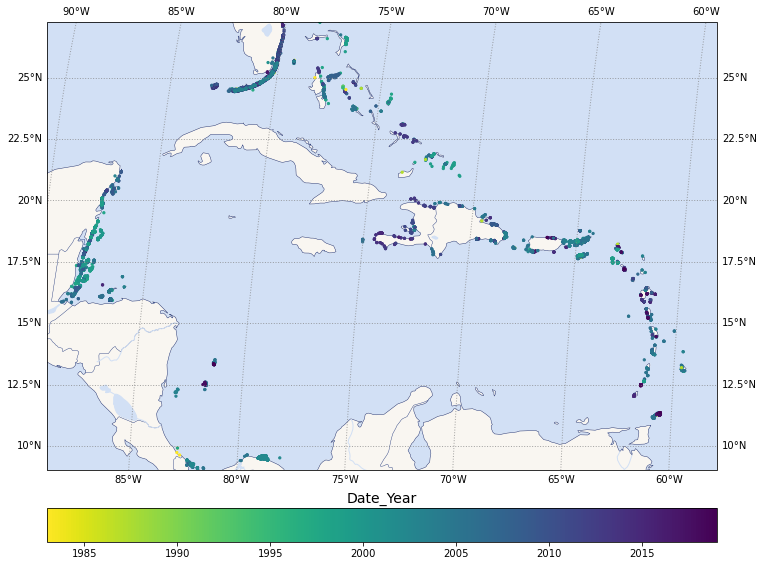

In [20]:
db_plt.plot_points(gdf, col='Date_Year')

In [21]:
#gdf_bl = gdf.where(gdf['Bleaching_Level'] > 0)

### Plot bleaching samples by Bleaching Level

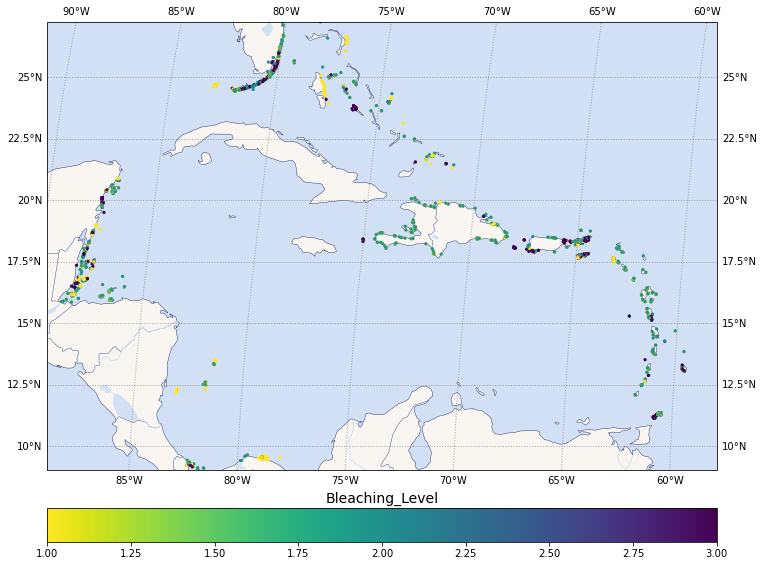

In [22]:
db_plt.plot_points(gdf.where(gdf['Bleaching_Level'] > 0), col='Bleaching_Level')

### Timeseries classification

As seen in the plots from the bleaching database, there are areas without any samples. 
In this section we are using a pre-trained binary classification model to predict if 
an area has bleached corals based on the sea surface temperatue timeseries of the areas locations.
Creating and training the model is not part of this workshop, but if you would like to see how it was done and/or further improve it after the workshop, 
the code is in a notebook called timeseries_classification. 

In [10]:
#Getting sea surface temperature timeseries for an area without samples in the bleaching database
ds_slice_predict =data.sel(lon=slice(-80,-75), lat=slice(18, 22), time=slice('2000-01-01', '2020-01-05'))

In [11]:
df = ds_slice_predict.to_dataframe().reset_index() ## This can take some time depending on size of slice

In [12]:
df.head()

time     lat        lon  analysed_sst    crs  \
0 2000-01-01 12:00:00  18.025 -79.974998     26.799999 -32767   
1 2000-01-01 12:00:00  18.025 -79.925003     26.820000 -32767   
2 2000-01-01 12:00:00  18.025 -79.875000     26.840000 -32767   
3 2000-01-01 12:00:00  18.025 -79.824997     26.859999 -32767   
4 2000-01-01 12:00:00  18.025 -79.775002     26.879999 -32767   

   sea_ice_fraction  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [13]:
#Get a list of sea surface temperature readings for all locations (lat-lon group)
df['analysed_sst'] = df['analysed_sst'].fillna(0)
df_grp= df.groupby(by=['lat', 'lon']).agg({'analysed_sst':lambda x: list(x)})

In [14]:
#remove locations where all the temperatures are NaN or 0
df_grp['sst_sum'] = df_grp.apply(lambda row: sum(row['analysed_sst']), axis = 1)
df_grp = df_grp.where(df_grp['sst_sum'] > 0).dropna()

#### Scale the temperatures

In [15]:
#Load the same sklearn StandardScaler as used when training the model
scaler = pickle.load(open('scaler.pkl','rb'))
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))

Mean: 27.950613, StandardDeviation: 1.111375


In [16]:
def data_scaler(data_list):
    scaled_array = scaler.transform(np.array(data_list).reshape(-1, 1))
    return scaled_array.reshape(scaled_array.shape[0]).tolist()

In [17]:
#Scale the all the temeratures in the list
df_grp['sst_scaled'] = df_grp.apply(lambda row: data_scaler(row['analysed_sst']), axis = 1)

#### import/install tensorflow and load the model

In [18]:
import sys
#!{sys.executable} -m pip install tensorflow
from tensorflow import keras
model = keras.models.load_model("./ts_classification_model.h5")

2022-05-02 08:20:13.817855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 08:20:13.817908: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-02 08:20:17.690402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 08:20:17.690459: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 08:20:17.690493: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-marie-2elepoutre-40cognite-2ecom): /proc/driver/nvidia/version does not exist
2022-05-02 08:20:17.691257: I tensor

#### Use model to predict whether corals on location are bleached or not

In [19]:
def data_predict(data_list):
    x_array = np.array(data_list[3000:7000]).reshape(1, 4000, 1)
    y_pred = model.predict(np.array(x_array))
    return np.argmax(y_pred, axis = 1)[0]

In [20]:
df_grp['bleached_predict'] = df_grp.apply(lambda row: data_predict(row['sst_scaled']), axis = 1) #This takes some time

In [21]:
df_grp_l = df_grp.reset_index()

In [22]:
df_grp_geo = gpd.GeoDataFrame(
    df_grp_l, geometry=gpd.points_from_xy(df_grp_l['lon'], df_grp_l['lat']))

### Plot the predictions on a map

The plot shows locations (betweeen South Cuba and North Jamacia) where corals are predicted to be bleached (1, dark color) and not bleached (0, yellow color).
Not all locations have coral reefs, this is not taken into considerations. 

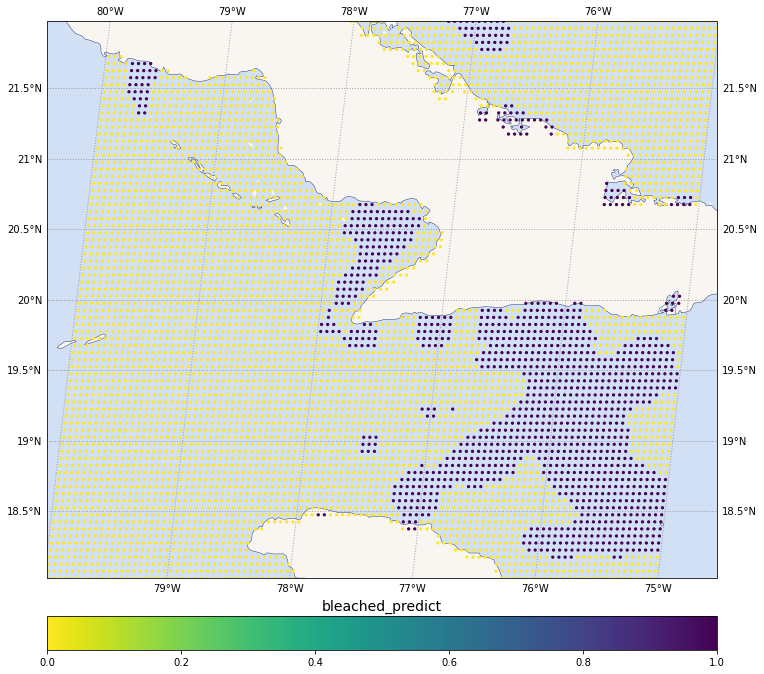

In [23]:
db_plt.plot_points(df_grp_geo, col='bleached_predict')

Let's take a smaller time subset of the xarray

In [ ]:
ds_slice =data.sel(lon=slice(-80,-78), lat=slice(20, 22), time=slice('1990-01-01', '2022-01-01'))
ds_slice

In [ ]:
%%time
df = ds_slice.to_dataframe().reset_index() ## This can take some time depending on size of slice
df['time'] = pd.to_datetime(df['time'],format='%m/%d/%y %I:%M%p')
df['mnth_yr'] = df.time.dt.to_period('M').astype(str)
df['year'] = df.time.dt.year.astype(str)
df['month'] = df.time.dt.month.astype(int)

In [ ]:
df.head()